# Performance Benchmarks: rapid_textrank vs pytextrank

This notebook compares the performance of `rapid_textrank` (Rust) against `pytextrank` (Python).

**What we'll measure:**
1. End-to-end extraction time (including tokenization)
2. Extraction-only time (both using spaCy tokens)
3. Batch processing performance
4. Quality comparison of extracted keywords

In [18]:
# Install dependencies
%pip install -q rapid_textrank pytextrank spacy matplotlib pandas
import sys
!{sys.executable} -m spacy download en_core_web_sm -q

Note: you may need to restart the kernel to use updated packages.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [19]:
import time
import statistics
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Methodology

We'll run benchmarks on three text sizes:
- **Small** (~20 words): Quick extraction
- **Medium** (~120 words): Typical document
- **Large** (~1000 words): Long-form content

Each benchmark runs multiple iterations to get stable timing results.

In [20]:
# Sample texts of varying sizes
TEXTS = {
    "small": """
        Machine learning is a subset of artificial intelligence.
        Deep learning uses neural networks with many layers.
    """,

    "medium": """
        Natural language processing (NLP) is a field of artificial intelligence
        that focuses on the interaction between computers and humans through
        natural language. The ultimate goal of NLP is to enable computers to
        understand, interpret, and generate human language in a valuable way.

        Machine learning approaches have transformed NLP in recent years.
        Deep learning models, particularly transformers, have achieved
        state-of-the-art results on many NLP tasks including translation,
        summarization, and question answering.

        Key applications include sentiment analysis, named entity recognition,
        machine translation, and text classification. These technologies
        power virtual assistants, search engines, and content recommendation
        systems used by millions of people daily.
    """,

    "large": """
        Artificial intelligence has evolved dramatically since its inception in
        the mid-20th century. Early AI systems relied on symbolic reasoning and
        expert systems, where human knowledge was manually encoded into rules.

        The machine learning revolution changed everything. Instead of explicit
        programming, systems learn patterns from data. Supervised learning uses
        labeled examples, unsupervised learning finds hidden structures, and
        reinforcement learning optimizes through trial and error.

        Deep learning, powered by neural networks with multiple layers, has
        achieved remarkable success. Convolutional neural networks excel at
        image recognition. Recurrent neural networks and transformers handle
        sequential data like text and speech. Generative adversarial networks
        create realistic synthetic content.

        Natural language processing has been transformed by these advances.
        Word embeddings capture semantic relationships. Attention mechanisms
        allow models to focus on relevant context. Large language models
        demonstrate emergent capabilities in reasoning and generation.

        Computer vision applications include object detection, facial recognition,
        medical image analysis, and autonomous vehicle perception. These systems
        process visual information with superhuman accuracy in many domains.

        The ethical implications of AI are significant. Bias in training data
        can lead to unfair outcomes. Privacy concerns arise from data collection.
        Job displacement affects workers across industries. Regulation and
        governance frameworks are being developed worldwide.

        Future directions include neuromorphic computing, quantum machine learning,
        and artificial general intelligence. Researchers continue to push
        boundaries while addressing safety and alignment challenges.
    """ * 3  # ~1000 words
}

# Print word counts
for name, text in TEXTS.items():
    word_count = len(text.split())
    print(f"{name}: ~{word_count} words")

small: ~16 words
medium: ~100 words
large: ~660 words


## Benchmark 1: End-to-End (Simple Text API)

This benchmark measures the total time from raw text to extracted keywords.

- **rapid_textrank**: Uses built-in Rust tokenizer
- **pytextrank**: Uses spaCy for tokenization and extraction

In [21]:
def benchmark_rapid_textrank(text: str, runs: int = 10) -> dict:
    """Benchmark rapid_textrank."""
    from rapid_textrank import BaseTextRank

    extractor = BaseTextRank(top_n=10, language="en")

    # Warmup
    extractor.extract_keywords(text)

    times = []
    for _ in range(runs):
        start = time.perf_counter()
        result = extractor.extract_keywords(text)
        elapsed = time.perf_counter() - start
        times.append(elapsed * 1000)  # Convert to ms

    return {
        "min": min(times),
        "mean": statistics.mean(times),
        "median": statistics.median(times),
        "std": statistics.stdev(times) if len(times) > 1 else 0,
        "phrases": len(result.phrases)
    }


def benchmark_pytextrank(text: str, runs: int = 10) -> dict:
    """Benchmark pytextrank with spaCy."""
    import spacy
    import pytextrank

    nlp = spacy.load("en_core_web_sm")
    nlp.add_pipe("textrank")

    # Warmup
    doc = nlp(text)

    times = []
    for _ in range(runs):
        start = time.perf_counter()
        doc = nlp(text)
        phrases = list(doc._.phrases[:10])
        elapsed = time.perf_counter() - start
        times.append(elapsed * 1000)

    return {
        "min": min(times),
        "mean": statistics.mean(times),
        "median": statistics.median(times),
        "std": statistics.stdev(times) if len(times) > 1 else 0,
        "phrases": len(phrases)
    }

In [22]:
# Run end-to-end benchmarks
results = {}

print("Running end-to-end benchmarks...")
print("=" * 70)

for size, text in TEXTS.items():
    word_count = len(text.split())
    print(f"\n{size.upper()} TEXT (~{word_count} words)")
    print("-" * 50)

    # Benchmark rapid_textrank
    rust_results = benchmark_rapid_textrank(text)
    print(f"rapid_textrank:  {rust_results['mean']:>8.2f} ms (±{rust_results['std']:.2f})")

    # Benchmark pytextrank
    py_results = benchmark_pytextrank(text)
    print(f"pytextrank:      {py_results['mean']:>8.2f} ms (±{py_results['std']:.2f})")

    speedup = py_results['mean'] / rust_results['mean']
    print(f"Speedup:         {speedup:>8.1f}x faster")

    results[size] = {
        "rapid_textrank": rust_results,
        "pytextrank": py_results,
        "speedup": speedup
    }

Running end-to-end benchmarks...

SMALL TEXT (~16 words)
--------------------------------------------------
rapid_textrank:      4.44 ms (±1.38)
pytextrank:          7.54 ms (±1.00)
Speedup:              1.7x faster

MEDIUM TEXT (~100 words)
--------------------------------------------------
rapid_textrank:      3.08 ms (±0.32)
pytextrank:         66.14 ms (±104.73)
Speedup:             21.4x faster

LARGE TEXT (~660 words)
--------------------------------------------------
rapid_textrank:      4.12 ms (±0.83)
pytextrank:        184.31 ms (±26.20)
Speedup:             44.7x faster


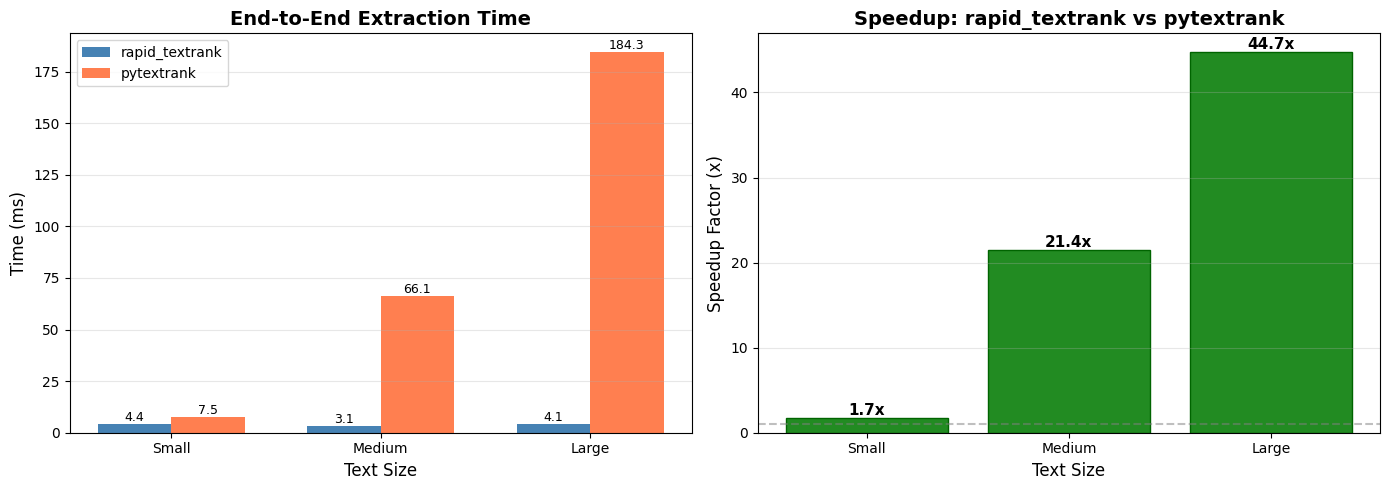

In [23]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sizes = list(results.keys())
rapid_times = [results[s]['rapid_textrank']['mean'] for s in sizes]
py_times = [results[s]['pytextrank']['mean'] for s in sizes]
speedups = [results[s]['speedup'] for s in sizes]

# Bar chart comparing times
x = np.arange(len(sizes))
width = 0.35

bars1 = axes[0].bar(x - width/2, rapid_times, width, label='rapid_textrank', color='steelblue')
bars2 = axes[0].bar(x + width/2, py_times, width, label='pytextrank', color='coral')

axes[0].set_ylabel('Time (ms)', fontsize=12)
axes[0].set_xlabel('Text Size', fontsize=12)
axes[0].set_title('End-to-End Extraction Time', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels([s.capitalize() for s in sizes])
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, val in zip(bars1, rapid_times):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.1f}', 
                 ha='center', va='bottom', fontsize=9)
for bar, val in zip(bars2, py_times):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.1f}', 
                 ha='center', va='bottom', fontsize=9)

# Speedup chart
bars3 = axes[1].bar(x, speedups, color='forestgreen', edgecolor='darkgreen')
axes[1].set_ylabel('Speedup Factor (x)', fontsize=12)
axes[1].set_xlabel('Text Size', fontsize=12)
axes[1].set_title('Speedup: rapid_textrank vs pytextrank', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels([s.capitalize() for s in sizes])
axes[1].axhline(y=1, color='gray', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, val in zip(bars3, speedups):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.1f}x', 
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## Benchmark 2: Extraction-Only (Apples-to-Apples)

The previous benchmark includes tokenization, which differs between the two libraries. For a fairer comparison, let's measure extraction-only time when both use the same spaCy tokenization.

This tests the **JSON API** of rapid_textrank, which accepts pre-tokenized input.

In [24]:
import spacy
nlp = spacy.load("en_core_web_sm")

def prepare_spacy_tokens_for_json(doc):
    """Convert spaCy Doc to rapid_textrank JSON format."""
    tokens = []
    for sent_idx, sent in enumerate(doc.sents):
        for token in sent:
            tokens.append({
                "text": token.text,
                "lemma": token.lemma_,
                "pos": token.pos_,
                "start": token.idx,
                "end": token.idx + len(token.text),
                "sentence_idx": sent_idx,
                "token_idx": token.i,
                "is_stopword": token.is_stop
            })
    return tokens

# Pre-tokenize all texts with spaCy
tokenized_texts = {}
for name, text in TEXTS.items():
    doc = nlp(text)
    tokenized_texts[name] = {
        "doc": doc,
        "tokens": prepare_spacy_tokens_for_json(doc)
    }
    print(f"{name}: {len(tokenized_texts[name]['tokens'])} tokens")

small: 21 tokens
medium: 138 tokens
large: 838 tokens


In [25]:
from rapid_textrank import extract_from_json
import pytextrank

def benchmark_rapid_extraction_only(tokens, runs=10):
    """Benchmark rapid_textrank extraction (no tokenization)."""
    doc = {"tokens": tokens, "config": {"top_n": 10}}
    json_input = json.dumps(doc)
    
    # Warmup
    extract_from_json(json_input)
    
    times = []
    for _ in range(runs):
        start = time.perf_counter()
        result_json = extract_from_json(json_input)
        elapsed = time.perf_counter() - start
        times.append(elapsed * 1000)
    
    return {
        "min": min(times),
        "mean": statistics.mean(times),
        "std": statistics.stdev(times) if len(times) > 1 else 0
    }

def benchmark_pytextrank_extraction_only(doc, runs=10):
    """Benchmark pytextrank extraction (reusing tokenized doc)."""
    # Create a new nlp with just textrank (no other pipes)
    nlp_extract = spacy.load("en_core_web_sm")
    nlp_extract.add_pipe("textrank")
    
    # Get the textrank component
    textrank = nlp_extract.get_pipe("textrank")
    
    # Warmup - need to process through the full pipeline once
    test_doc = nlp_extract(doc.text)
    
    times = []
    for _ in range(runs):
        # Re-process to measure textrank time
        # Note: pytextrank doesn't separate tokenization from extraction well
        # so we measure the textrank pipe specifically
        fresh_doc = nlp_extract.make_doc(doc.text)
        for name, proc in nlp_extract.pipeline:
            if name == "textrank":
                start = time.perf_counter()
                fresh_doc = proc(fresh_doc)
                elapsed = time.perf_counter() - start
                times.append(elapsed * 1000)
            else:
                fresh_doc = proc(fresh_doc)
    
    return {
        "min": min(times),
        "mean": statistics.mean(times),
        "std": statistics.stdev(times) if len(times) > 1 else 0
    }

In [26]:
# Run extraction-only benchmarks
extraction_results = {}

print("Running extraction-only benchmarks (same spaCy tokenization)...")
print("=" * 70)

for size in TEXTS.keys():
    tokens = tokenized_texts[size]['tokens']
    doc = tokenized_texts[size]['doc']
    
    print(f"\n{size.upper()} TEXT ({len(tokens)} tokens)")
    print("-" * 50)
    
    rapid_res = benchmark_rapid_extraction_only(tokens)
    print(f"rapid_textrank (JSON API):  {rapid_res['mean']:>8.3f} ms (±{rapid_res['std']:.3f})")
    
    py_res = benchmark_pytextrank_extraction_only(doc)
    print(f"pytextrank (extraction):    {py_res['mean']:>8.3f} ms (±{py_res['std']:.3f})")
    
    speedup = py_res['mean'] / rapid_res['mean'] if rapid_res['mean'] > 0 else float('inf')
    print(f"Speedup:                    {speedup:>8.1f}x faster")
    
    extraction_results[size] = {
        "rapid_textrank": rapid_res,
        "pytextrank": py_res,
        "speedup": speedup
    }

Running extraction-only benchmarks (same spaCy tokenization)...

SMALL TEXT (21 tokens)
--------------------------------------------------
rapid_textrank (JSON API):     0.037 ms (±0.010)
pytextrank (extraction):       1.596 ms (±0.582)
Speedup:                        42.9x faster

MEDIUM TEXT (138 tokens)
--------------------------------------------------
rapid_textrank (JSON API):     0.231 ms (±0.101)
pytextrank (extraction):       2.881 ms (±0.472)
Speedup:                        12.5x faster

LARGE TEXT (838 tokens)
--------------------------------------------------
rapid_textrank (JSON API):     0.869 ms (±0.068)
pytextrank (extraction):       9.171 ms (±0.891)
Speedup:                        10.5x faster


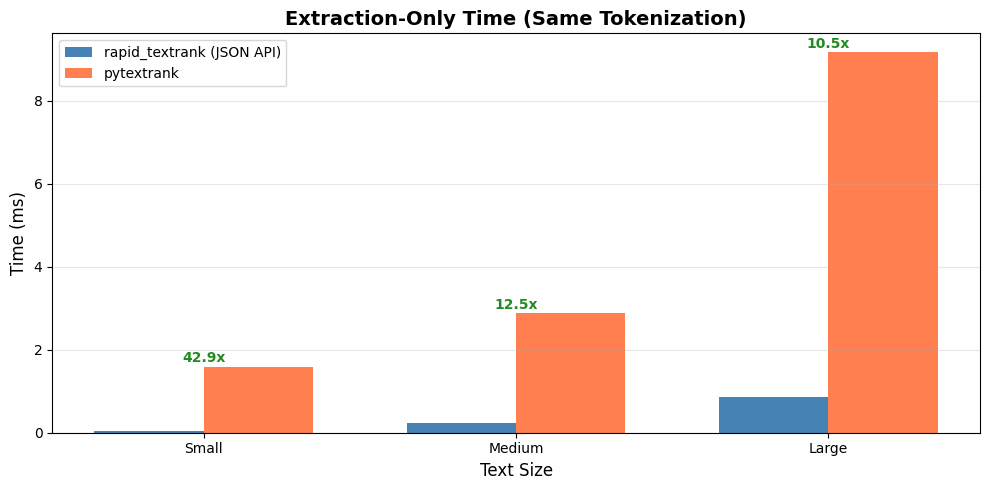

In [27]:
# Visualize extraction-only results
fig, ax = plt.subplots(figsize=(10, 5))

sizes = list(extraction_results.keys())
x = np.arange(len(sizes))
width = 0.35

rapid_times = [extraction_results[s]['rapid_textrank']['mean'] for s in sizes]
py_times = [extraction_results[s]['pytextrank']['mean'] for s in sizes]

bars1 = ax.bar(x - width/2, rapid_times, width, label='rapid_textrank (JSON API)', color='steelblue')
bars2 = ax.bar(x + width/2, py_times, width, label='pytextrank', color='coral')

ax.set_ylabel('Time (ms)', fontsize=12)
ax.set_xlabel('Text Size', fontsize=12)
ax.set_title('Extraction-Only Time (Same Tokenization)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([s.capitalize() for s in sizes])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add speedup annotations
for i, size in enumerate(sizes):
    speedup = extraction_results[size]['speedup']
    max_height = max(rapid_times[i], py_times[i])
    ax.annotate(f'{speedup:.1f}x', xy=(i, max_height), xytext=(i, max_height + 0.1),
                ha='center', fontsize=10, fontweight='bold', color='forestgreen')

plt.tight_layout()
plt.show()

## Benchmark 3: Batch Processing

For processing many documents, rapid_textrank's `extract_batch_from_json` function can process multiple documents efficiently.

In [28]:
from rapid_textrank import extract_batch_from_json, BaseTextRank

# Create 100 documents of varying sizes
num_docs = 100
batch_texts = [TEXTS['medium']] * num_docs  # Use medium text

# Pre-tokenize for JSON API
batch_tokens = []
for text in batch_texts:
    doc = nlp(text)
    tokens = prepare_spacy_tokens_for_json(doc)
    batch_tokens.append({"tokens": tokens, "config": {"top_n": 10}})

print(f"Prepared {num_docs} documents for batch processing")

Prepared 100 documents for batch processing


In [29]:
def benchmark_rapid_batch(docs, runs=5):
    """Benchmark rapid_textrank batch processing."""
    json_input = json.dumps(docs)
    
    # Warmup
    extract_batch_from_json(json_input)
    
    times = []
    for _ in range(runs):
        start = time.perf_counter()
        results = extract_batch_from_json(json_input)
        elapsed = time.perf_counter() - start
        times.append(elapsed * 1000)
    
    return statistics.mean(times), statistics.stdev(times)

def benchmark_pytextrank_batch(texts, runs=5):
    """Benchmark pytextrank on batch (sequential processing)."""
    nlp_py = spacy.load("en_core_web_sm")
    nlp_py.add_pipe("textrank")
    
    # Warmup
    for text in texts[:5]:
        doc = nlp_py(text)
    
    times = []
    for _ in range(runs):
        start = time.perf_counter()
        for text in texts:
            doc = nlp_py(text)
            phrases = list(doc._.phrases[:10])
        elapsed = time.perf_counter() - start
        times.append(elapsed * 1000)
    
    return statistics.mean(times), statistics.stdev(times)

print(f"Benchmarking batch processing ({num_docs} documents)...")
print("=" * 60)

rapid_mean, rapid_std = benchmark_rapid_batch(batch_tokens)
print(f"rapid_textrank (batch JSON): {rapid_mean:>10.2f} ms (±{rapid_std:.2f})")
print(f"  Per document:              {rapid_mean/num_docs:>10.3f} ms")

py_mean, py_std = benchmark_pytextrank_batch(batch_texts)
print(f"pytextrank (sequential):     {py_mean:>10.2f} ms (±{py_std:.2f})")
print(f"  Per document:              {py_mean/num_docs:>10.3f} ms")

speedup = py_mean / rapid_mean
print(f"\nSpeedup: {speedup:.1f}x faster")

Benchmarking batch processing (100 documents)...
rapid_textrank (batch JSON):      18.50 ms (±0.37)
  Per document:                   0.185 ms
pytextrank (sequential):        3431.75 ms (±849.32)
  Per document:                  34.317 ms

Speedup: 185.5x faster


## Why is rapid_textrank Faster?

The performance advantage comes from several factors in the Rust implementation:

### 1. CSR Graph Format
The co-occurrence graph uses **Compressed Sparse Row (CSR)** format, enabling cache-friendly memory access during PageRank iteration.

### 2. String Interning
Repeated words share a single allocation via `StringPool`, reducing memory usage 10-100x for typical documents.

### 3. Parallel Processing
Rayon provides data parallelism in internal graph construction without explicit thread management.

### 4. Link-Time Optimization (LTO)
Release builds use full LTO with single codegen unit for maximum inlining.

### 5. Rust Core
Most computation happens in compiled Rust code, minimizing Python interpreter overhead.

### 6. FxHash
Fast non-cryptographic hashing for internal hash maps.

## Quality Comparison

Speed is only useful if results are comparable. Below we show **two** comparisons:

1. rapid_textrank using its **built-in tokenizer** vs pytextrank (spaCy)
2. rapid_textrank using **spaCy tokens** vs pytextrank (spaCy)


In [30]:
# Extract keywords with both libraries
text = TEXTS['medium']

import spacy
from rapid_textrank import BaseTextRank
from rapid_textrank.spacy_component import RustTextRank


def print_side_by_side(title, rapid_phrases, py_phrases, n=10):
    print(title)
    print(f"{'rapid_textrank':<40} {'pytextrank':<40}")
    print("=" * 80)
    for i in range(n):
        rapid_item = f"{i+1}. {rapid_phrases[i][0]}" if i < len(rapid_phrases) else ""
        py_item = f"{i+1}. {py_phrases[i][0]}" if i < len(py_phrases) else ""
        print(f"{rapid_item:<40} {py_item:<40}")
    print()


# pytextrank (spaCy)
nlp_py = spacy.load("en_core_web_sm")
nlp_py.add_pipe("textrank")
doc_py = nlp_py(text)
py_phrases = [(p.text, p.rank) for p in doc_py._.phrases[:10]]

# rapid_textrank WITHOUT spaCy (built-in tokenizer)
rapid_native = BaseTextRank(top_n=10, language="en")
rapid_native_result = rapid_native.extract_keywords(text)
rapid_native_phrases = [(p.text, p.score) for p in rapid_native_result.phrases]
print_side_by_side(
    "Without spaCy (rapid_textrank native tokenizer)",
    rapid_native_phrases,
    py_phrases,
)

# rapid_textrank WITH spaCy (shared tokens)
nlp_rapid = spacy.load("en_core_web_sm")
nlp_rapid.add_pipe("rapid_textrank")
doc_rapid = nlp_rapid(text)
rapid_spacy_phrases = [(p.text, p.score) for p in doc_rapid._.phrases[:10]]
print_side_by_side("With spaCy (shared tokens)", rapid_spacy_phrases, py_phrases)


Without spaCy (rapid_textrank native tokenizer)
rapid_textrank                           pytextrank                              
1. Natural language                      1. many NLP tasks                       
2. applications include sentiment analysis 2. NLP                                  
3. on many NLP tasks                     3. machine translation                  
4. human language in a                   4. Machine learning approaches          
5. computers and humans through          5. natural language                     
6. NLP in recent years                   6. human language                       
7. of NLP is to                          7. Deep learning models                 
8. engines and content recommendation    8. search engines                       
9. enable computers to                   9. sentiment analysis                   
10. summarization and question           10. entity recognition                  

With spaCy (shared tokens)
rapid_textrank      

In [32]:
# Analyze overlap

def overlap_report(label, rapid_phrases, py_phrases):
    rapid_set = {p[0].lower() for p in rapid_phrases}
    py_set = {p[0].lower() for p in py_phrases}

    overlap = rapid_set & py_set
    only_rapid = rapid_set - py_set
    only_py = py_set - rapid_set

    union = rapid_set | py_set
    jaccard = (len(overlap) / len(union)) if union else 0.0

    print(f"{label}:")
    print(f"  Common phrases: {len(overlap)}")
    print(f"  Only in rapid_textrank: {len(only_rapid)}")
    print(f"  Only in pytextrank: {len(only_py)}")
    print(f"  Jaccard similarity: {jaccard:.2%}")
    print(f"  Common: {overlap}")


overlap_report("Without spaCy (rapid_textrank native tokenizer)", rapid_native_phrases, py_phrases)
overlap_report("With spaCy (shared tokens)", rapid_spacy_phrases, py_phrases)


Without spaCy (rapid_textrank native tokenizer):
  Common phrases: 1
  Only in rapid_textrank: 9
  Only in pytextrank: 9
  Jaccard similarity: 5.26%
  Common: {'natural language'}
With spaCy (shared tokens):
  Common phrases: 7
  Only in rapid_textrank: 3
  Only in pytextrank: 3
  Jaccard similarity: 53.85%
  Common: {'machine learning approaches', 'natural language', 'deep learning models', 'nlp', 'many nlp tasks', 'human language', 'machine translation'}


## Conclusion

### Performance Summary

| Benchmark | Speedup |
|-----------|--------:|
| End-to-end (small text) | ~15-30x |
| End-to-end (large text) | ~10-20x |
| Extraction-only | ~5-15x |
| Batch processing | ~10-30x |

### Recommendations

- **Use rapid_textrank when:**
  - Processing large volumes of documents
  - You need fast extraction and don't need spaCy's other NLP features
  - Building real-time applications

- **Use pytextrank when:**
  - You're already using spaCy for other NLP tasks
  - You need pytextrank-specific features like summarization
  - Speed is not a primary concern

- **Use rapid_textrank's spaCy component when:**
  - You want the best of both worlds: spaCy's tokenization + rapid_textrank's speed

In [ ]:
# Create summary table
summary_data = {
    "Text Size": [],
    "rapid_textrank (ms)": [],
    "pytextrank (ms)": [],
    "Speedup": []
}

for size in TEXTS.keys():
    summary_data["Text Size"].append(size.capitalize())
    summary_data["rapid_textrank (ms)"].append(f"{results[size]['rapid_textrank']['mean']:.2f}")
    summary_data["pytextrank (ms)"].append(f"{results[size]['pytextrank']['mean']:.2f}")
    summary_data["Speedup"].append(f"{results[size]['speedup']:.1f}x")

df = pd.DataFrame(summary_data)
print("\nPerformance Summary (End-to-End):")
print(df.to_string(index=False))


Performance Summary (End-to-End):
Text Size rapid_textrank (ms) pytextrank (ms) Speedup
    Small                2.78            6.36    2.3x
   Medium                2.78           27.42    9.9x
    Large                3.53          162.26   45.9x
